supply and demand analysis
calculate changes in oil reserves, including the SPR, weekly and compared to last year
determine if changes are in line with expectations
if not in line with expectations determine if it is due to higher demand, lower production, more exports or a combination

In [7]:
import pandas as pd
import USA_oil_data as oil
import prices
from FRED_oil_data import get_fred_data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
#sns.set()
sns.set_style("whitegrid")

In [12]:
weekly_stocks = oil.ending_stocks(just_crude=True)
spr = oil.spr_reserves()

/Users/nickgault/PycharmProjects/Kayak/Oil_analysis/USA_oil_data.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('period').sum()['value']
/Users/nickgault/PycharmProjects/Kayak/Oil_analysis/USA_oil_data.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('period').sum()['value']


In [13]:
merged = pd.merge(weekly_stocks, spr, on='period')
merged.sort_index(inplace=True)

In [14]:
ticks = [x for x in range(0, 1400000, 200000)]

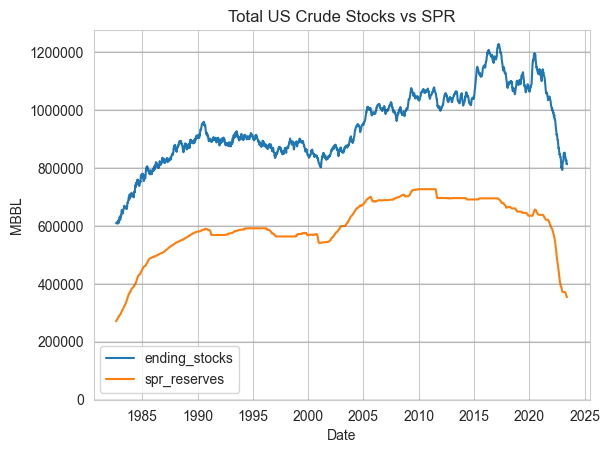

In [15]:
plt.plot(merged)

plt.yticks(ticks)
plt.ticklabel_format(axis='y', style='plain')
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.legend(merged.columns)
plt.title("Total US Crude Stocks vs SPR")
plt.xlabel('Date')
plt.ylabel('MBBL')
plt.show()

In [20]:
weekly_stocks = oil.ending_stocks(just_crude=True).to_frame()

/Users/nickgault/PycharmProjects/Kayak/Oil_analysis/USA_oil_data.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby('period').sum()['value']


In [21]:
display(weekly_stocks.head())

,ending_stocks
period,
1982-08-20,609219
1982-08-27,608741
1982-09-24,612419
1982-10-01,612419
1982-10-08,613985


In [22]:
weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month
weekly_stocks = weekly_stocks[weekly_stocks['year'] > 2015]
monthly_average = weekly_stocks.groupby('month').mean()

In [23]:
grouped = weekly_stocks.groupby('year')

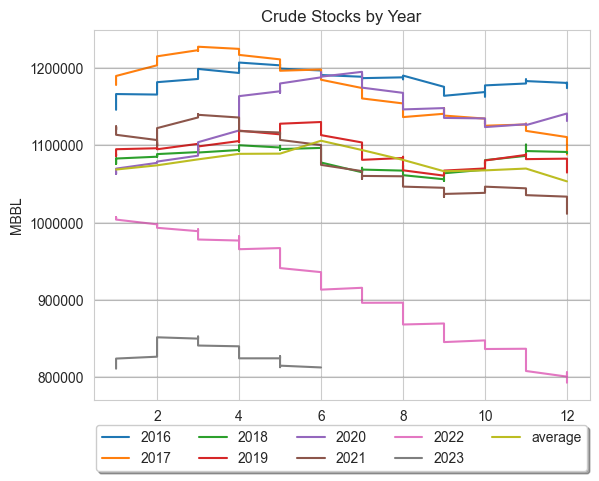

In [25]:
fig, ax = plt.subplots()

for name, group in grouped:
    ax.plot(group['month'], group['ending_stocks'], label=name)
ax.plot(monthly_average.index, monthly_average['ending_stocks'], label='average' )
plt.ticklabel_format(axis='y', style='plain')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5)

#add horizontal lines
ticks = [x for x in range(800000, 1300000, 100000)]
for t in ticks:
    plt.axhline(t, color='black', alpha=0.1)

plt.title('Crude Stocks by Year')
plt.xlabel('Month')
plt.ylabel('MBBL')
plt.show()

In [10]:
weekly_stocks = oil.weekly_stocks()
weekly_stocks = weekly_stocks.to_frame()

weekly_stocks['year'] = weekly_stocks.index.year
weekly_stocks['month'] = weekly_stocks.index.month

weekly_stocks['diff'] = weekly_stocks['stocks'].diff(-1)
weekly_stocks = weekly_stocks[weekly_stocks['year'] >= 2018]

week_info = weekly_stocks.index.isocalendar()
week_number = week_info['week']

merged_df = pd.merge(week_number, weekly_stocks, left_index=True, right_index=True)

In [11]:
grouped = merged_df.groupby('year')

In [12]:
weeks = grouped['week'].unique()
years = len(grouped['year'].unique())
width = 0.8/years

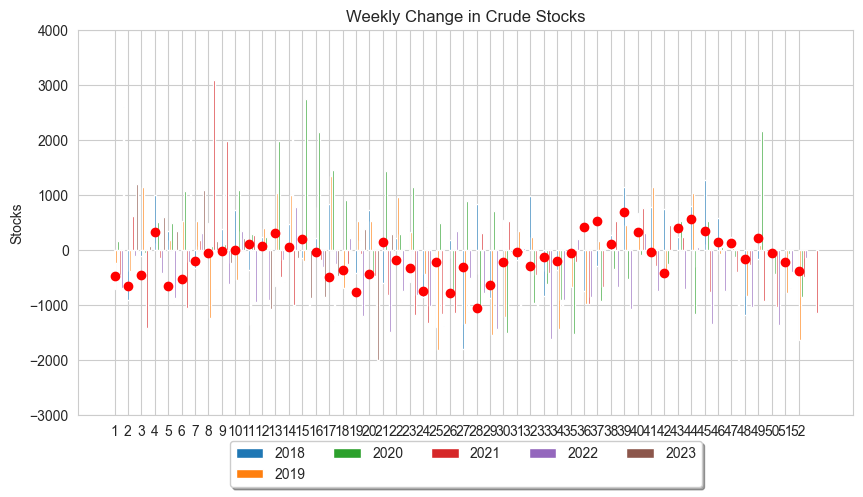

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
i = 0
week = {i:0 for i in range(1, 53)}
week_count = {i:0 for i in range(1, 53)}

for name, group in grouped:
    data = group[group['week'] < 53]
    data = group['diff']/7
    positions = group['week']

    for p in positions[positions < 53]:
        week[p] += data[p-1]
        week_count[p] += 1


    ax.bar(positions + i * width, data, width=width, label=name)
    i += 1


means = []
for sum, count in zip(week.values(), week_count.values()):
    means.append(sum/count)

means_df = pd.DataFrame(means)
plt.plot(means_df.index+1, means_df, 'ro')
plt.xticks(range(1, 53))

plt.ylim(-3000,4000)

ax.set_ylabel('Stocks')
ax.set_xlabel('Week')
#move legend to bottom
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Weekly Change in Crude Stocks')

plt.show()

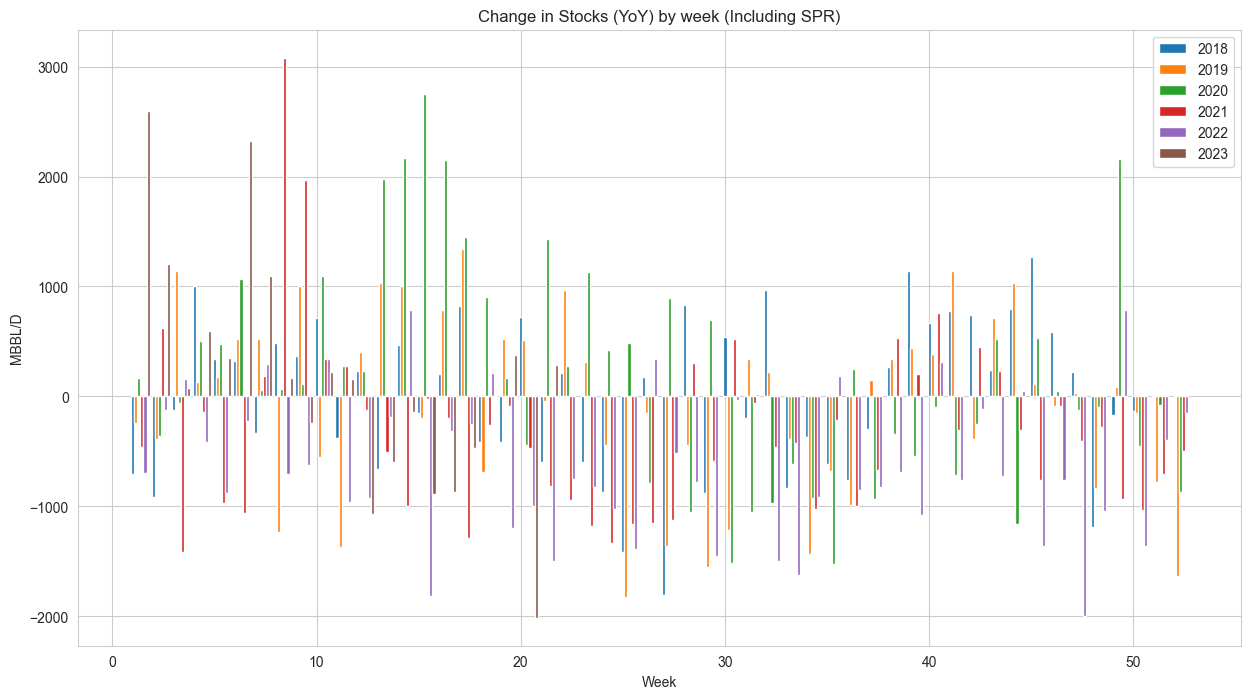

In [14]:
pos = 0
width = 0.15
fig, ax = plt.subplots(figsize=(15,8))
for name, group in grouped:
    position = group['week']
    position = position[position < 53]

    data = group['diff'] / 7
    data = data[:52]
    ax.bar(position + pos * width, data, width=width, label=name)
    pos += 1
plt.legend()
plt.xlabel('Week')
plt.ylabel('MBBL/D')
plt.title('Change in Stocks (YoY) by week (Including SPR)')
plt.show()

------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------

week_sum = {i:0 for i in range(1, 53)}
week_count = {i:0 for i in range(1, 53)}
week_max = {i:0 for i in range(1, 53)}
week_min = {i:10000000000 for i in range(1, 53)}

for name, group in grouped:
    for g in group.iterrows():
        week = g[1]['week']
        if week == 53:
            continue
        stock = g[1]['stocks']
        week_sum[week] += stock
        week_count[week] += 1
        if stock > week_max[week]:
            week_max[week] = stock
        if stock < week_min[week]:
            week_min[week] = stock

week_avg = {k: v/week_count[k] for k, v in week_sum.items()}

fig, ax = plt.subplots(figsize=(15,8))
plt.plot(week_avg.keys(), week_avg.values(), label='Average')
plt.plot(week_max.keys(), week_max.values(), label='Max')
plt.plot(week_min.keys(), week_min.values(), label='Min')
plt.plot(group['week'], group['stocks'], label=name)
plt.legend()

In [3]:
imports, exports = oil.imports_exports(only_crude=True)

In [4]:
imports_exports = pd.merge(imports, exports, on='period')

imports_exports['year'] = imports_exports.index.year
imports_exports = imports_exports[imports_exports['year'] > 2005]

In [5]:
imports_exports['net'] = imports_exports['imports'] - imports_exports['exports']

Text(0.5, 1.0, 'Imports, Exports and Net Imports')

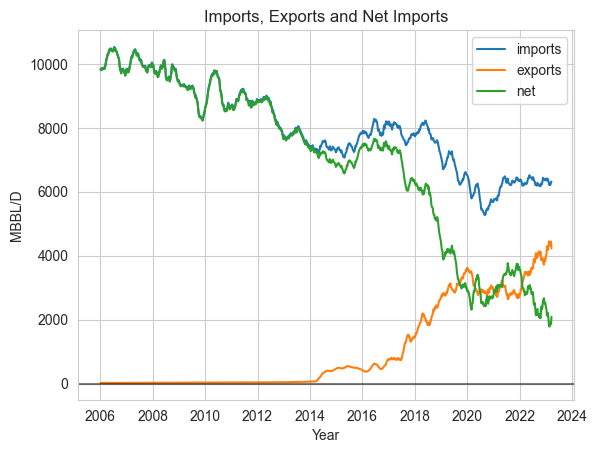

In [6]:
plt.plot(imports_exports[['imports', 'exports', 'net']].rolling(12).mean())
plt.legend(imports_exports[['imports', 'exports', 'net']])
plt.axhline(0, color='black', alpha=0.5)
plt.xlabel('Year')
plt.ylabel('MBBL/D')
plt.title('Imports, Exports and Net Imports')

In [19]:
def convert_to_monthly(data, name='value'):
    data['days_in_month'] = data.index.days_in_month
    data['imports'] = data['imports'] * data['days_in_month']
    data['exports'] = data['exports'] * data['days_in_month']
    data = data[['imports', 'exports']]
    data['net_imports'] = data['imports'] - data['exports']
    data['net'] = data['imports'] - data['exports']
    data = data['net']
    data = data.rename(name)
    return data

In [20]:
#supply data:

#production
production = oil.mbbl_production()

#reserves
reserves = oil.crude_oil_stocks()

#imports
imports = oil.imports()

#demand data:
#product supplied
product_supplied = oil.weekly_product_supplied()
monthly_product_supplied = product_supplied.resample('M').sum()
monthly_product_supplied.index = monthly_product_supplied.index - pd.offsets.MonthBegin(1)
monthly_product_supplied.rename("monthly_product_supplied", inplace=True)

#exprots
exports = oil.exports()

#refinery/blender net inputs
net_refinery = oil.refinery_net_input()
#sales (not updated since March 2022)
#gas_end_users = oil.gasoline_sales_end_user()
#gas_resale = oil.gasoline_sales_resale()


In [21]:
net_imports = imports - exports
net_imports.rename('net_imports', inplace=True)

period
2023-03-01    46128
2023-02-01    72754
2023-01-01    85668
2022-12-01    66261
2022-11-01    66028
              ...  
1920-05-01     6205
1920-04-01     5493
1920-03-01     5611
1920-02-01     4087
1920-01-01     5825
Name: net_imports, Length: 1239, dtype: int64

In [22]:
#merge all data into one dataframe
#supply_demand = pd.merge(production, reserves, on='period') exclude reserves
supply_demand = pd.merge(production, monthly_product_supplied, on='period')
supply_demand = pd.merge(supply_demand, net_imports, on='period')
supply_demand = pd.merge(supply_demand, net_refinery, on='period')

In [23]:
changes = supply_demand.diff(12)
#changes = supply_demand.pct_change(12)

demand: (an increase in these values should be positive on the SD chart)
- refinery net inputs (if refinery net inputs are higher than last year then demand is higher)
- monthly product supplied (if monthly product supplied is higher than last year then demand is higher)

supply: (an increase on these values should be negative on the SD chart as it represents an increase in supply)
- production (if production is higher than last year then supply is higher)
- net imports (if net imports are higher than last year then demand is higher)

In [24]:
#convert MBBL to MBBL/D
changes = changes/30

In [25]:
positive_values = changes[changes > 0].sum(axis=1)
negative_values = changes[changes < 0].sum(axis=1)

sd = positive_values + negative_values
sd.rename('sd', inplace=True)

period
2007-06-01      0.000000
2007-07-01      0.000000
2007-08-01      0.000000
2007-09-01      0.000000
2007-10-01      0.000000
                 ...    
2022-11-01    261.366667
2022-12-01   -956.566667
2023-01-01    218.466667
2023-02-01    398.600000
2023-03-01   -465.233333
Name: sd, Length: 190, dtype: float64

In [26]:
changes = changes[changes.index > '2000-12-01']
changes.index = changes.index.strftime('%Y-%m')

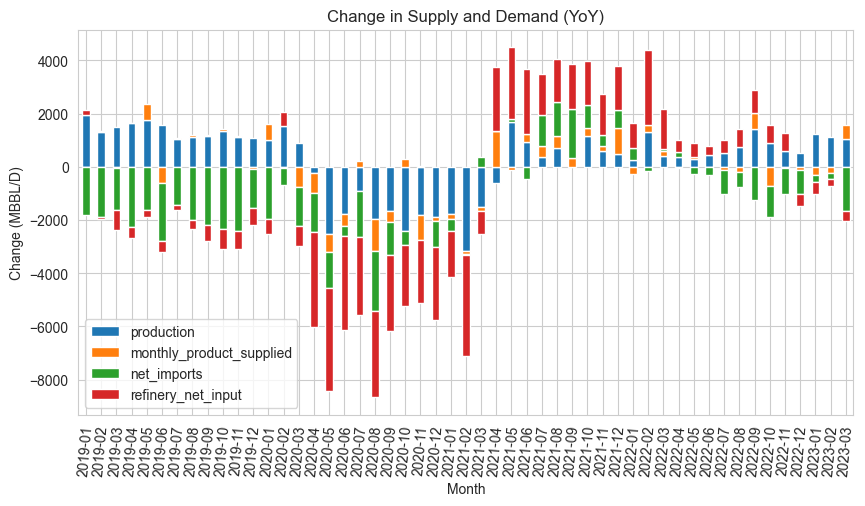

In [27]:
changes = changes[changes.index > '2018-12-01']
fig, ax = plt.subplots(figsize=(10,5))
changes.plot(kind='bar', stacked=True, ax=ax)
plt.title('Change in Supply and Demand (YoY)')
ax.set_xlabel('Month')
ax.set_ylabel('Change (MBBL/D)')
plt.xticks(rotation=85)
plt.show()

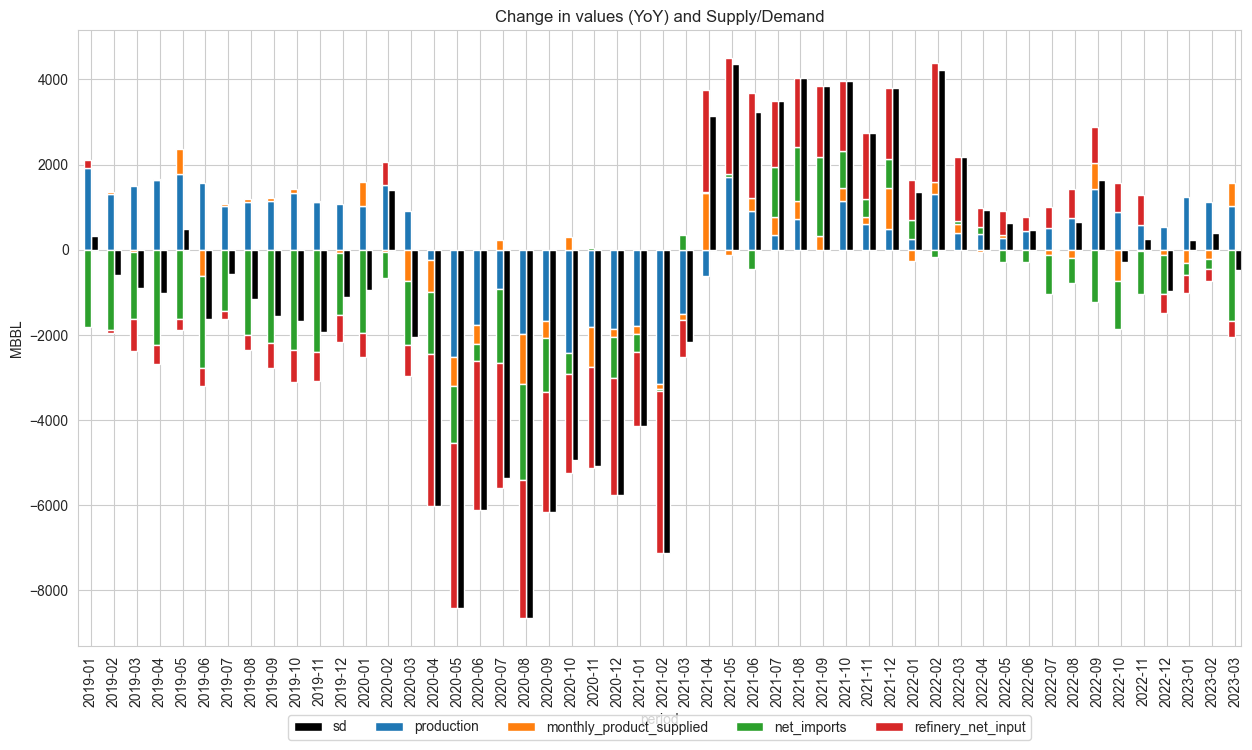

In [28]:
sd_data = sd[sd.index > '2018-12-01']
ax = sd_data.plot.bar(ylabel="MBBL", xlabel="Date", figsize=(15,8),
                 color='black', position=0, width=0.3)

changes.plot.bar(stacked=True, sharex=True, ax=ax, position=1, width=0.3)
#for t in range(-250000, 150000, 50000):
#    plt.axhline(t, color='black', alpha=0.1)

plt.title('Change in values (YoY) and Supply/Demand')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)

<Axes: xlabel='period'>

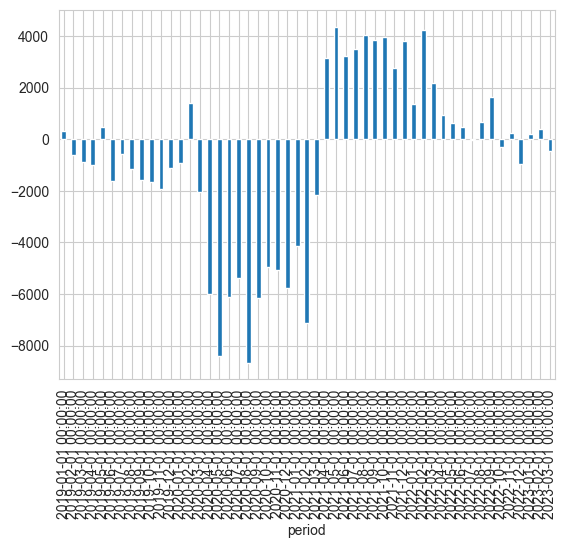

In [29]:
sd_data = sd[sd.index > '2018-12-01']
sd_data.plot(kind='bar')

In [30]:
monthly_net_imports = net_imports
monthly_net_imports = monthly_net_imports[monthly_net_imports.index > '2018-12-01']
monthly_net_imports.index = monthly_net_imports.index.strftime('%Y-%m')

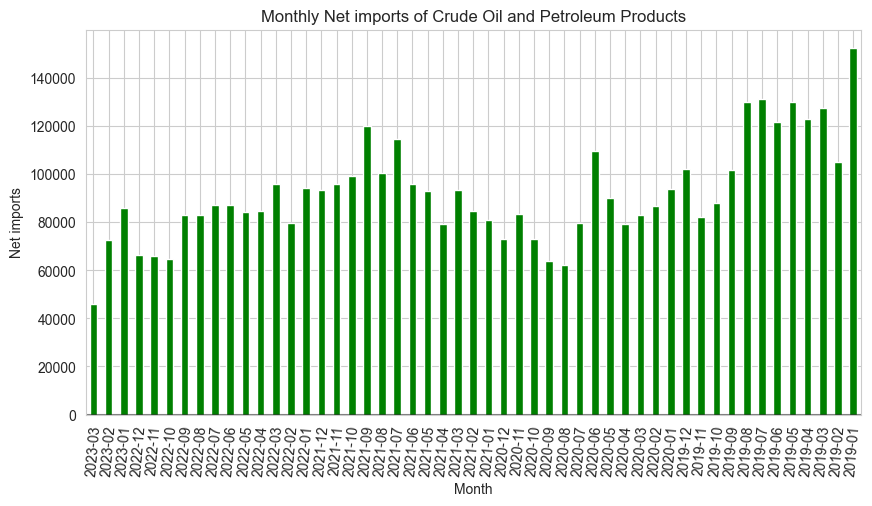

In [31]:
fig, ax = plt.subplots(figsize=(10,5))

monthly_net_imports.plot(kind='bar', ax=ax)
for i, val in enumerate(monthly_net_imports):
    if val > 0:
        ax.patches[i].set_facecolor('green')
    else:
        ax.patches[i].set_facecolor('red')

plt.axhline(0, color='black', alpha=0.5)
ax.set_xlabel('Month')
ax.set_ylabel('Net imports')

plt.xticks(rotation=85)
plt.title('Monthly Net imports of Crude Oil and Petroleum Products')
plt.show()

In [32]:
spr_changes = spr.diff(52)

In [33]:
spr_changes = spr_changes[spr_changes.index > "2018-12-01"]

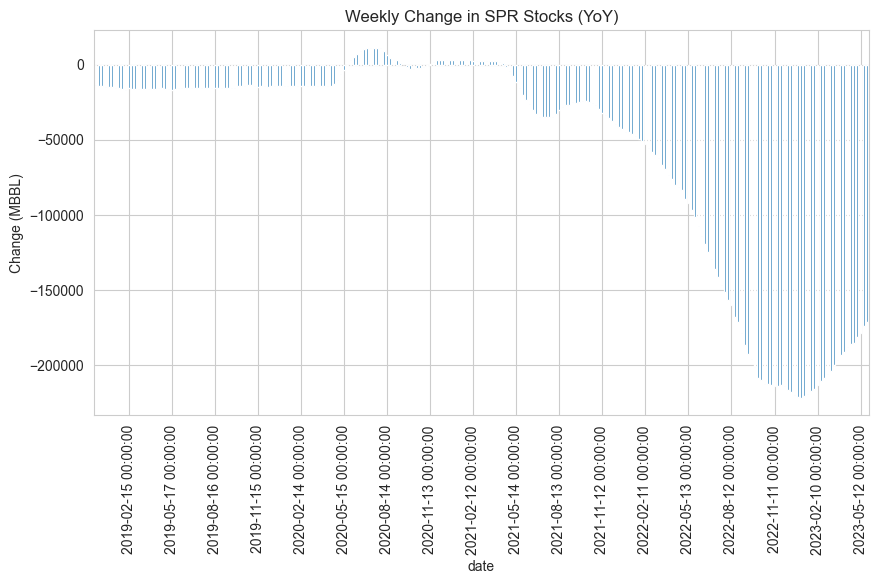

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
spr_changes.plot(kind='bar', ax=ax)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=13))
ax.set_xlabel('date')
ax.set_ylabel('Change (MBBL)')
plt.title('Weekly Change in SPR Stocks (YoY)')
plt.show()

In [35]:
sd = sd.to_frame()

In [36]:
sd.index = pd.to_datetime(sd.index)

In [37]:
sd['year'] = sd.index.year
sd['month'] = sd.index.month

In [38]:
sd['diff'] = sd['sd'].diff(12)
sd = sd[sd.index > '2016-12-01']

In [39]:
grouped = sd.groupby(['year'])

In [40]:
sd

,sd,year,month,diff
period,,,,
2017-01-01,-167.300000,2017,1,-924.366667
2017-02-01,-2025.366667,2017,2,-3878.500000
2017-03-01,515.533333,2017,3,229.800000
2017-04-01,623.466667,2017,4,602.600000
2017-05-01,1639.000000,2017,5,2583.600000
...,...,...,...,...
2022-11-01,261.366667,2022,11,-2490.533333
2022-12-01,-956.566667,2022,12,-4760.166667
2023-01-01,218.466667,2023,1,-1145.500000


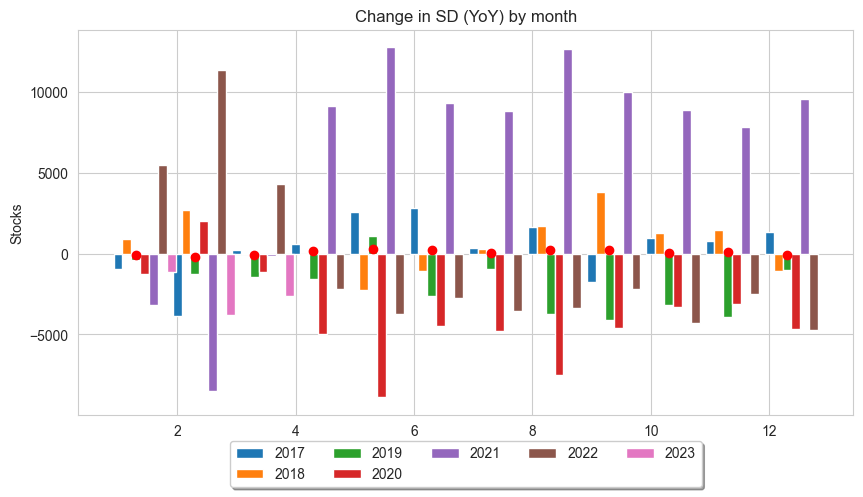

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
i = 0
means = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
counts = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0}
for name, group in grouped:
    year = str(name)[1:5]
    positions = group['month']
    data = group['diff']
    for row in group.iterrows():
        means[int(row[1]['month'])] += int(row[1]['diff'])
        counts[int(row[1]['month'])] += 1


    ax.bar(positions + i * width, data, width=width, label=year)
    i += 1



ax.set_ylabel('Stocks')
ax.set_xlabel('Week')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.title('Change in SD (YoY) by month')

#calculate means for every month
means_df = pd.DataFrame.from_dict(means, orient='index')
means_df.rename(columns={0:'sums'}, inplace=True)
counts_df = pd.DataFrame.from_dict(counts, orient='index')
means_df['counts'] = counts_df
means_df['mean'] = means_df['sums'] / means_df['counts']

#plot means as red dot
plt.plot(means_df.index+0.3, means_df['mean'], 'ro')


plt.show()

In [49]:
forecast = oil.crude_production_forecast(end='2025-01', start='2015-01')

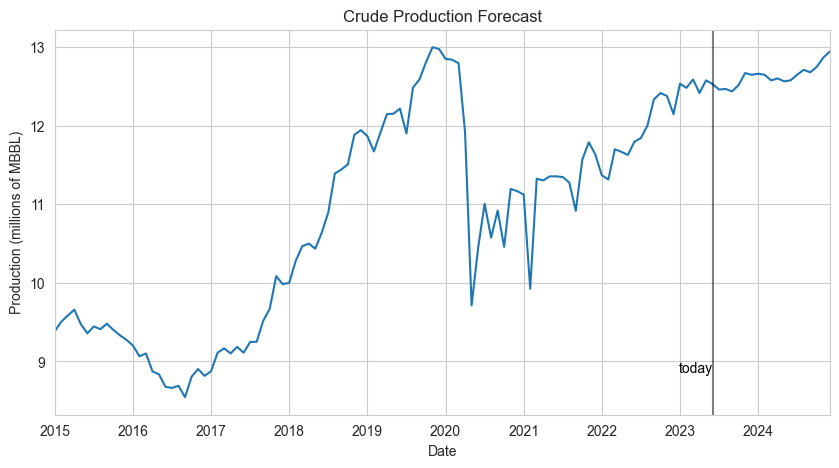

In [50]:
fig, ax = plt.subplots(figsize=(10,5))
forecast.plot(ax=ax)

plt.axvline(pd.to_datetime('today'), color='black', alpha=0.5)
plt.text(pd.to_datetime('today'), 9, 'today', ha='right', va='top', color='black')

plt.title('Crude Production Forecast')
plt.xlabel('Date')
plt.ylabel('Production (millions of MBBL)')

plt.show()

In [51]:
prod, cons = oil.world_prod_cons(end='2025-01', start='2015-01')

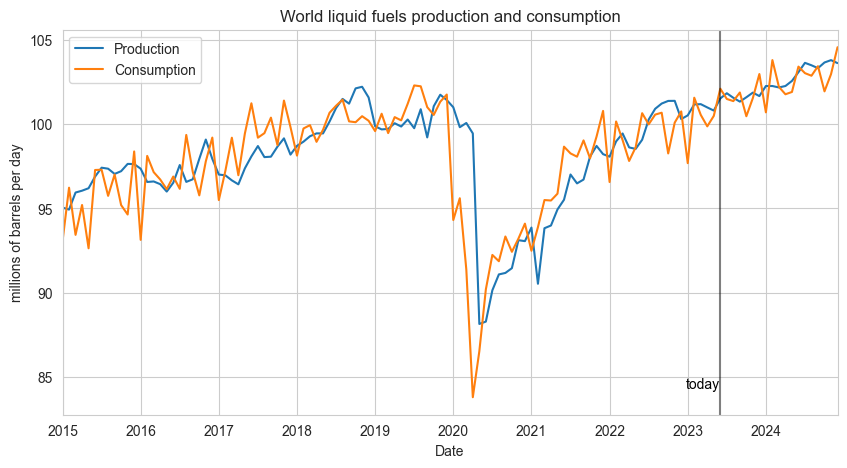

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
prod.plot(ax=ax, label='Production')
cons.plot(ax=ax, label='Consumption')

plt.axvline(pd.to_datetime('today'), color='black', alpha=0.5)
plt.text(pd.to_datetime('today'), 85, 'today', ha='right', va='top', color='black')

plt.title('World liquid fuels production and consumption')
plt.xlabel('Date')
plt.ylabel('millions of barrels per day')

plt.legend()

In [1]:
today = pd.to_datetime('today').date()

NameError: name 'pd' is not defined

In [ ]:
print(today)